#### Imports

In [1]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# pip install librosa

#### Reading the files from our folder and creating a dataframe from it

In [22]:
#list the files
filelist = os.listdir('male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [23]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [24]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [25]:
df_male.head()

,file,label
0,1034-121119-0000.flac,1
1,1034-121119-0001.flac,1
2,1034-121119-0002.flac,1
3,1034-121119-0003.flac,1
4,1034-121119-0004.flac,1


In [26]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


Doing the same for the female folder

In [27]:
filelist = os.listdir('female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [28]:
df_female['label']='0'

In [29]:
df_female = df_female.rename(columns={0:'file'})

In [30]:
df_female.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [31]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label


In [32]:
# Dropping the system file
df_female.drop(981, inplace=True)

In [33]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

Joining both dataframes together 

In [34]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [35]:
df.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [36]:
# Randomizing our files to be able to split into train, validation and test
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:
# We will be using our saved randomized df to replicate results
# Any randomized df can be used but we already had the features for this randomized df

# df = pd.read_csv('randomized_df.csv')

We are going to do an split of train, validation and test with 70% train, 20% validation and 10% for test. We check that the randomized splits have balanced classes

In [38]:
df_train = df[:9188]

In [39]:
df_train['label'].value_counts(normalize=True)

0    0.502939
1    0.497061
Name: label, dtype: float64

In [40]:
df_validation = df[9188:11813]

In [41]:
df_validation['label'].value_counts(normalize=True)

0    0.506286
1    0.493714
Name: label, dtype: float64

In [42]:
df_test = df[11813:13125]

In [43]:
df_test['label'].value_counts(normalize=True)

0    0.501524
1    0.498476
Name: label, dtype: float64

#### Function to extract the features and label for each sound file by iterating through every row of the dataframe

In [25]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [26]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [27]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

C:\Users\HP\anaconda3\envs\env_keras\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [28]:
# Code to see how long it took
print(datetime.now() - startTime)

16:52:25.659527


In [29]:
# Checking how the output looks
features_label

0        ([-328.5816720452944, 85.87195624078662, -49.9...
1        ([-307.6894420559929, 110.9649212561915, -45.3...
2        ([-358.00295577465675, 117.5835700986468, -9.3...
3        ([-355.06083239008376, 88.34999542062481, -33....
4        ([-318.5989875740335, 129.76020629132722, -7.3...
                               ...                        
28533    ([-340.7793494639668, 135.28464185097585, -14....
28534    ([-340.9911666273202, 107.00306204076443, -33....
28535    ([-368.1721100929296, 94.43879857575195, -46.6...
28536    ([-309.1848815257454, 89.2659702175946, -64.10...
28537    ([-331.91729510028, 130.47425386103984, -18.55...
Length: 28538, dtype: object

In [30]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_label)

In [2]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)

In [3]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [4]:
len(features)

28538

In [5]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_label)):
    labels.append(features_label[i][5])

In [6]:
len(labels)

28538

#### Checking if we have balanced classes for the whole data

In [7]:
np.unique(labels, return_counts=True)

(array(['0', '1'], dtype='<U1'), array([14341, 14197], dtype=int64))

#### Hot encoding y and pre processing X and y

In [8]:
# Setting our X as a numpy array to feed into the neural network
X = np.array(features)

In [9]:
# Setting our y
y = np.array(labels)

In [10]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [11]:
# Checking our shapes
X.shape

(28538, 193)

In [12]:
# Checking our shapes
y.shape

(28538, 2)

In [25]:
# Choosing the first 9188 (70%) files to be our train data
# Choosing the next  2625 (20%) files to be our validation data
# Choosing the next  1312 (10%) files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:9188]
y_train = y[:9188]

X_val = X[9188:11813]
y_val = y[9188:11813]

X_test = X[11813:]
y_test = y[11813:]

Scaling our data

In [18]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [19]:
X_train

array([[ 0.38340474, -1.622843  , -1.28519737, ..., -1.29613779,
        -2.38512584, -2.90421318],
       [ 0.93792637, -0.23999032, -1.0456188 , ...,  0.18730379,
         0.35182642,  0.57267038],
       [-0.39749506,  0.12475798,  0.86091093, ...,  0.67410491,
         1.37180366,  1.1367968 ],
       ...,
       [-0.19040183, -0.36659432,  0.75656337, ...,  0.58712424,
         0.55088409,  0.6130114 ],
       [-1.20949188, -2.34761586, -2.00269756, ..., -3.44290379,
         1.12181529, -3.42204816],
       [-0.70009441, -0.37037523, -1.81273618, ..., -0.15479158,
        -0.04481633,  0.1783347 ]])

In [26]:
from pickle import load
ss = load(open('scaler.pkl', 'rb'))

In [27]:
X_train = ss.fit_transform(X_train)

In [28]:
X_train

array([[ 0.38340474, -1.622843  , -1.28519737, ..., -1.29613779,
        -2.38512584, -2.90421318],
       [ 0.93792637, -0.23999032, -1.0456188 , ...,  0.18730379,
         0.35182642,  0.57267038],
       [-0.39749506,  0.12475798,  0.86091093, ...,  0.67410491,
         1.37180366,  1.1367968 ],
       ...,
       [-0.19040183, -0.36659432,  0.75656337, ...,  0.58712424,
         0.55088409,  0.6130114 ],
       [-1.20949188, -2.34761586, -2.00269756, ..., -3.44290379,
         1.12181529, -3.42204816],
       [-0.70009441, -0.37037523, -1.81273618, ..., -0.15479158,
        -0.04481633,  0.1783347 ]])

In [21]:
# save the scaler
from pickle import dump
dump(ss, open('scaler.pkl', 'wb'))

#### Building the neural network

In [16]:
# Build a simple dense model with early stopping with softmax for categorical classification
# Note that we use softmax for binary classification because it gives us a better result
# than sigmoid for our probabilities in case we decide to use a voting classifier 

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [73]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=64, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Train on 9188 samples, validate on 2625 samples
Epoch 1/100
9188/9188 [==============================] - 4s 477us/sample - loss: 2.2631e-04 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 2/100
9188/9188 [==============================] - 1s 116us/sample - loss: 8.5906e-04 - accuracy: 0.9996 - val_loss: 0.0253 - val_accuracy: 0.9947
Epoch 3/100
9188/9188 [==============================] - 1s 115us/sample - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9950
Epoch 4/100
9188/9188 [==============================] - 1s 109us/sample - loss: 2.2469e-04 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9958
Epoch 5/100
9188/9188 [==============================] - 1s 110us/sample - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0445 - val_accuracy: 0.9939
Epoch 6/100
9188/9188 [==============================] - 1s 126us/sample - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0201 - val_accuracy: 0.9954
Epoch 7/100
9188/9188 [=======================

Epoch 55/100
9188/9188 [==============================] - 1s 93us/sample - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0268 - val_accuracy: 0.9943
Epoch 56/100
9188/9188 [==============================] - 1s 98us/sample - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0178 - val_accuracy: 0.9962
Epoch 57/100
9188/9188 [==============================] - 1s 99us/sample - loss: 7.1540e-05 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9962
Epoch 58/100
9188/9188 [==============================] - 1s 101us/sample - loss: 9.1024e-05 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9970
Epoch 59/100
9188/9188 [==============================] - 1s 103us/sample - loss: 2.8332e-04 - accuracy: 0.9999 - val_loss: 0.0303 - val_accuracy: 0.9947
Epoch 60/100
9188/9188 [==============================] - 1s 103us/sample - loss: 1.8758e-04 - accuracy: 0.9999 - val_loss: 0.0202 - val_accuracy: 0.9966
Epoch 61/100
9188/9188 [==============================] - 1s 99us/sample - loss: 6.2968

In [18]:
# Checking how our model looks like and how many parameters it has
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 193)               37442     
_________________________________________________________________
dropout (Dropout)            (None, 193)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

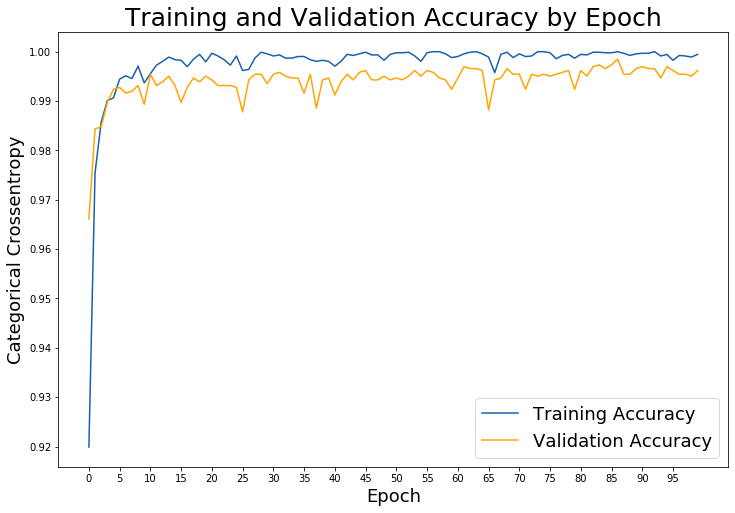

In [19]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [20]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

In [44]:
df_test = df[11813:]

In [45]:
df_test['preds'] = preds

C:\Users\HP\anaconda3\envs\env_keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
df_test

,file,label,preds
11813,289-121652-0002.flac,0,0
11814,4898-28461-0066.flac,1,1
11815,1098-133695-0055.flac,0,0
11816,1098-133695-0035.flac,0,0
11817,8465-246942-0016.flac,0,0
...,...,...,...
28533,4788-91208-0018.flac,1,1
28534,322-124147-0069.flac,0,0
28535,125-121342-0048.flac,0,0
28536,1743-142914-0027.flac,1,1


In [47]:
df_test['label'] = df_test['label'].astype(int)

C:\Users\HP\anaconda3\envs\env_keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
# Slicing our dataframe into the files we got wrong from our predictions
df_test[df_test['label'] != df_test['preds']]

,file,label,preds
11852,4406-16882-0036.flac,1,0
11980,6563-63821-0022.flac,1,0
12133,4406-16882-0052.flac,1,0
12433,118-121721-0005.flac,1,0
12523,322-124146-0014.flac,0,1
...,...,...,...
27624,6272-70168-0027.flac,0,1
27663,322-124146-0037.flac,0,1
27686,669-129061-0063.flac,0,1
28320,8419-286667-0024.flac,1,0


In [49]:
1-round(len(df_test[df_test['label'] != df_test['preds']])/len(df_test),3)

0.995

#### 99.5% accurate on test data

But it is test data from the speakers we have trained the model on

In [50]:
#Checking how many different speakers we have

speakers = []
for i in range(0, len(df)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(df['file'][i].split('-')[0])

len(set(speakers))

251

#### We will try again and add new test data with speakers that our model has never heard before

In [51]:
#list the files
filelist = os.listdir('test_male') 
#read them into pandas
df_test_male = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_male['label']=1

# Renaming the column name to file
df_test_male = df_test_male.rename(columns={0:'file'})

df_test_male.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_male[df_test_male['file']=='.DS_Store']

,file,label


In [52]:
# Dropping the system file
df_test_male.drop(6, inplace=True)

# Resetting the index since we dropped a row
df_test_male = df_test_male.reset_index(drop=True)

In [53]:
df_test_male.head()

,file,label
0,1089-134686-0000.flac,1
1,1089-134686-0001.flac,1
2,1089-134686-0002.flac,1
3,1089-134686-0003.flac,1
4,1089-134686-0004.flac,1


In [54]:
#list the files
filelist = os.listdir('test_female') 
#read them into pandas
df_test_female = pd.DataFrame(filelist)

# Adding the 1 label to the dataframe representing male
df_test_female['label']=0

# Renaming the column name to file
df_test_female = df_test_female.rename(columns={0:'file'})

df_test_female.head()

# Checking for a file that gets automatically generated and we need to drop 
df_test_female[df_test_female['file']=='.DS_Store']

,file,label


In [55]:
# Dropping the system file
df_test_female.drop(7, inplace=True)

# Resetting the index since we dropped a row
df_test_female = df_test_female.reset_index(drop=True)

In [56]:
df_test_female.head()

,file,label
0,121-121726-0000.flac,0
1,121-121726-0001.flac,0
2,121-121726-0002.flac,0
3,121-121726-0003.flac,0
4,121-121726-0004.flac,0


In [57]:
test_new = pd.concat([df_test_male, df_test_female], ignore_index=True)

In [58]:
test_new.head()

,file,label
0,1089-134686-0000.flac,1
1,1089-134686-0001.flac,1
2,1089-134686-0002.flac,1
3,1089-134686-0003.flac,1
4,1089-134686-0004.flac,1


In [59]:
#Checking how many different new speakers we have

speakers = []
for i in range(0, len(test_new)):
    # The first numbers of each file represent the id of the speaker 
    speakers.append(test_new['file'][i].split('-')[0])

len(set(speakers))

40

In [60]:
# Again, the modified function to extract features from our new test data

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('new_test_male_female')+'/'+str(files.file))
    print(file_name)

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [61]:
# Extracting the features of our new test data
features_label_test_new = test_new.apply(extract_features, axis=1)

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1089-134686-0011.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0029.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0030.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0031.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0032.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0033.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0034.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0035.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0036.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0037.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0038.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1188-133604-0039.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0021.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0022.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0023.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0024.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0025.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0026.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2300-131720-0027.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/260-123440-0016.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0065.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0066.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0067.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0068.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0069.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0070.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0071.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0072.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0073.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0074.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2830-3980-0075.flac
D:\Voice Classification\Code\Gen

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5105-28241-0016.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0037.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0038.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0039.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0040.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0041.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0042.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0043.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0044.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0045.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0046.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/61-70968-0047.flac
D:\Voice Classification\Code\Gender_Classif

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0027.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0028.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0029.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0030.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0031.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0032.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0033.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0034.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0035.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0036.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/672-122797-0037.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-76324-0024.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-76324-0025.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-76324-0026.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-76324-0027.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-76324-0028.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6930-81414-0005.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7127-75946-0011.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-88083-0023.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-88083-0024.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-88083-0025.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-88083-0026.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-88083-0027.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7176-92135-0005.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0041.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0042.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0043.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0044.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0045.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/7729-102255-0046.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8224-274381-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8224-274381-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8224-274381-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8224-274381-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8224-274381-0004.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8455-210777-0020.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/908-31957-0010.flac
D:\Voice Classification\Code\Gen

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135766-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1221-135767-0000.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1284-134647-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1284-134647-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1284-134647-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1284-134647-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1284-134647-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141083-0005.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0033.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0034.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0035.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0036.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0037.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0038.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0039.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0040.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0041.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0042.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/1580-141084-0043.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2094-142345-0013.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/237-134493-0018.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0021.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/2961-961-0022.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3570-5694-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3570-5694-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3570-5694-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3570-5694-0003.flac
D:\Voice Classification\Code\Gender_Cla

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0036.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0037.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0038.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0039.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0040.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0041.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0042.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0043.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0044.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0045.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/3575-170457-0046.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4446-2273-0010.flac
D:\Voice Classification\Code\Gen

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4507-16021-0020.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0021.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0022.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0023.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0024.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0025.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0026.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0027.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0028.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/4970-29095-0029.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5142-33396-0021.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0003.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0004.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0005.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/5683-32865-0012.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0021.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0022.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0023.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0024.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0025.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0026.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0027.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0028.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0029.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/6829-68769-0030.flac
D:\Voice Classificati

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0006.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0007.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0008.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0009.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0010.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0011.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0012.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0013.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8463-294825-0016.flac
D:\Voice C

D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0014.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0015.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0016.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0017.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0018.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0019.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-284449-0020.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-292519-0000.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-292519-0001.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-292519-0002.flac
D:\Voice Classification\Code\Gender_Classifier\new_test_male_female/8555-292519-0003.flac
D:\Voice C

In [62]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label_test_new', features_label_test_new)

In [63]:
# loading the features
features_label_test_new = np.load('features_label_test_new.npy', allow_pickle=True)

In [65]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 
# Note that we are not using the label at all even though we kept it in the dataframe
# for comparisson and accuracy verification

features_new_test = []
for i in range(0, len(features_label_test_new)):
    features_new_test.append(np.concatenate((features_label_test_new[i][0], features_label_test_new[i][1], 
                features_label_test_new[i][2], features_label_test_new[i][3],
                features_label_test_new[i][4]), axis=0))

In [66]:
X_new_test = np.array(features_new_test)

In [67]:
X_new_test = ss.transform(X_new_test)

In [68]:
preds_new_test = model.predict_classes(X_new_test)

In [69]:
test_new['preds'] = preds_new_test

In [70]:
test_new[test_new['label'] != test_new['preds']]

,file,label,preds
3,1089-134686-0003.flac,1,0
229,260-123286-0020.flac,1,0
253,260-123288-0012.flac,1,0
271,260-123440-0001.flac,1,0
279,260-123440-0009.flac,1,0
...,...,...,...
2544,8463-294828-0027.flac,0,1
2547,8463-294828-0030.flac,0,1
2548,8463-294828-0031.flac,0,1
2549,8463-294828-0032.flac,0,1


In [71]:
1-round(len(test_new[test_new['label'] != test_new['preds']])/len(test_new),2)

0.9299999999999999

#### We got 92% accuracy on our new speakers

In [72]:
#Commenting to avoid mistake of saving again
model.save("trained_models/Gender_Classifier_NN.h5")